In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd

# Veri seti yolları
DATA_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
COVID_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5"
ADDITIONAL_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data"

print(f"Pneumonia Dataset: {DATA_DIR}")
print(f"COVID Dataset: {COVID_DIR}")
print(f"Additional Dataset: {ADDITIONAL_DIR}")

Matplotlib is building the font cache; this may take a moment.


Veri seti dizini: /Users/erenaskin/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
test
chest_xray
__MACOSX
train
val


## Sınıf Dağılımı
3 farklı veri setinin birleşimiyle oluşan toplam **Normal**, **Pneumonia** ve **COVID-19** görüntü sayılarına bakalım.

           Count
NORMAL     13358
PNEUMONIA   9891
COVID-19    4192


           Count
NORMAL     13358
PNEUMONIA   9891
COVID-19    4192


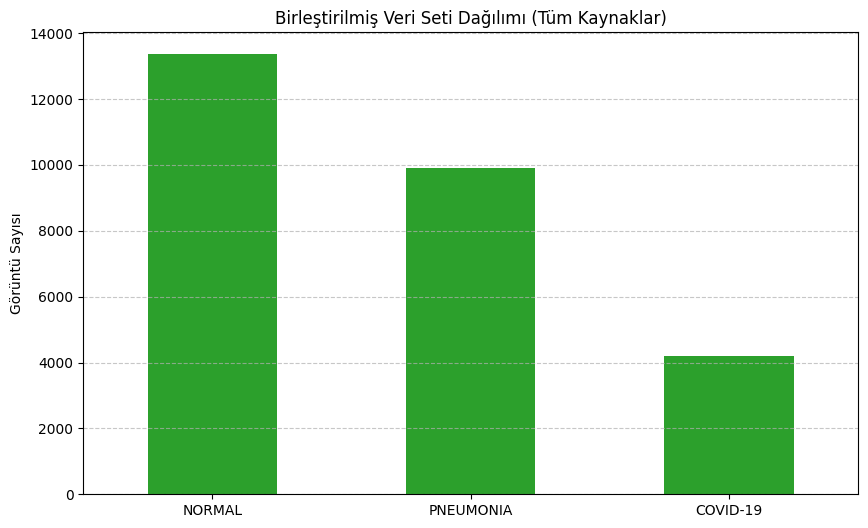

In [4]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Veri seti yolları (Hücre tek başına çalıştırılırsa diye)
DATA_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
COVID_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5"
ADDITIONAL_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data"

def get_combined_distribution():
    counts = {"NORMAL": 0, "PNEUMONIA": 0, "COVID-19": 0}
    
    # 1. DATA_DIR (Pneumonia Dataset) - Has train/test/val
    for split in ['train', 'test', 'val']:
        for label in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(DATA_DIR, split, label)
            if os.path.exists(path):
                counts[label] += len(os.listdir(path))

    # 2. COVID_DIR (COVID-19 Radiography Database)
    # Bu veri setinin yapısı bazen farklılık gösterebilir, glob ile aramak daha güvenli
    def count_covid_db(subdir):
        # Alt klasörlerde recursive arama yap
        files = glob.glob(os.path.join(COVID_DIR, '**', subdir, 'images', '*.png'), recursive=True)
        if not files:
             # Alternatif yol (images klasörü olmayabilir)
             files = glob.glob(os.path.join(COVID_DIR, '**', subdir, '*.png'), recursive=True)
        return len(files)

    counts["COVID-19"] += count_covid_db("COVID")
    counts["NORMAL"] += count_covid_db("Normal")
    counts["PNEUMONIA"] += count_covid_db("Viral Pneumonia")

    # 3. ADDITIONAL_DIR (Prashant268) - Has train/test
    for split in ['train', 'test']:
        # Normal
        path = os.path.join(ADDITIONAL_DIR, split, 'NORMAL')
        if os.path.exists(path): counts["NORMAL"] += len(os.listdir(path))
        
        # Pneumonia
        path = os.path.join(ADDITIONAL_DIR, split, 'PNEUMONIA')
        if os.path.exists(path): counts["PNEUMONIA"] += len(os.listdir(path))
        
        # COVID19
        path = os.path.join(ADDITIONAL_DIR, split, 'COVID19')
        if os.path.exists(path): counts["COVID-19"] += len(os.listdir(path))
        
    return counts

counts = get_combined_distribution()
df_dist = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])
print(df_dist)

# Görselleştirme
colors = ['#2ca02c', '#ff7f0e', '#d62728'] # Green, Orange, Red
df_dist.plot(kind='bar', figsize=(10, 6), color=colors, legend=False)
plt.title("Birleştirilmiş Veri Seti Dağılımı (Tüm Kaynaklar)")
plt.ylabel("Görüntü Sayısı")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Örnek Görüntüler
Normal, Zatürre (Pneumonia) ve COVID-19 sınıflarından rastgele örnekler.

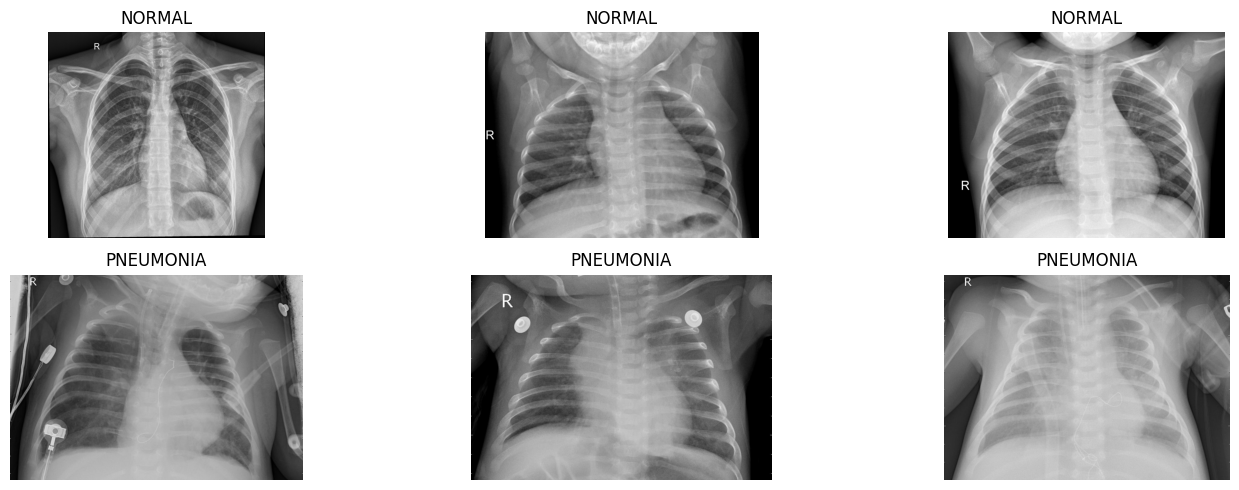

In [ ]:
import random

def show_samples_combined(num_samples=3):
    plt.figure(figsize=(15, 10))
    classes = ['NORMAL', 'PNEUMONIA', 'COVID-19']
    
    # Helper to get random images from the sources
    def get_random_images(label, n):
        images = []
        
        # 1. DATA_DIR
        if label in ['NORMAL', 'PNEUMONIA']:
            p = os.path.join(DATA_DIR, 'train', label)
            if os.path.exists(p):
                imgs = [os.path.join(p, f) for f in os.listdir(p) if f.endswith(('.jpeg', '.jpg', '.png'))]
                images.extend(imgs)
        
        # 2. COVID_DIR & ADDITIONAL_DIR (For COVID-19)
        if label == 'COVID-19':
            # COVID_DIR
            files = glob.glob(os.path.join(COVID_DIR, '**', 'COVID', 'images', '*.png'), recursive=True)
            images.extend(files)
                
            # ADDITIONAL_DIR
            p = os.path.join(ADDITIONAL_DIR, 'train', 'COVID19')
            if os.path.exists(p):
                imgs = [os.path.join(p, f) for f in os.listdir(p) if f.endswith(('.jpg', '.png'))]
                images.extend(imgs)
                
        if images:
            return random.sample(images, min(len(images), n))
        return []

    for idx, label in enumerate(classes):
        sample_paths = get_random_images(label, num_samples)
        
        for i, img_path in enumerate(sample_paths):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                plt.subplot(3, num_samples, idx * num_samples + i + 1)
                plt.imshow(img)
                plt.title(label)
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples_combined()

In [ ]:
import numpy as np

def show_average_images(num_samples=500):
    plt.figure(figsize=(15, 5))
    classes = ['NORMAL', 'PNEUMONIA', 'COVID-19']
    
    # Helper to get random images
    def get_random_images(label, n):
        images = []
        # 1. DATA_DIR
        if label in ['NORMAL', 'PNEUMONIA']:
            p = os.path.join(DATA_DIR, 'train', label)
            if os.path.exists(p):
                imgs = [os.path.join(p, f) for f in os.listdir(p) if f.endswith(('.jpeg', '.jpg', '.png'))]
                images.extend(imgs)
        # 2. COVID_DIR & ADDITIONAL_DIR (For COVID-19)
        if label == 'COVID-19':
            files = glob.glob(os.path.join(COVID_DIR, '**', 'COVID', 'images', '*.png'), recursive=True)
            images.extend(files)
            p = os.path.join(ADDITIONAL_DIR, 'train', 'COVID19')
            if os.path.exists(p):
                imgs = [os.path.join(p, f) for f in os.listdir(p) if f.endswith(('.jpg', '.png'))]
                images.extend(imgs)
        
        if images:
            return random.sample(images, min(len(images), n))
        return []

    for idx, label in enumerate(classes):
        sample_paths = get_random_images(label, num_samples)
        if not sample_paths: continue
            
        avg_img = np.zeros((224, 224, 3), float)
        count = 0
        
        for img_path in sample_paths:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                avg_img += img
                count += 1
        
        if count > 0:
            avg_img = avg_img / count
            avg_img = np.array(avg_img, dtype=np.uint8)
            avg_img = cv2.cvtColor(avg_img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(1, 3, idx + 1)
            plt.imshow(avg_img)
            plt.title(f"Average {label} ({count} samples)")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Ortalama görüntüler hesaplanıyor... (Bu işlem biraz sürebilir)")
show_average_images()